In [57]:
import pandas as pd
import numpy as np
import scipy.sparse as sps
from matplotlib import pyplot
from scipy.sparse import *
from scipy.stats import loguniform

In [15]:
urm_path = '/content/data_train.csv'

urm_all_df = pd.read_csv(filepath_or_buffer=urm_path,
                                sep=",",
                                header=0,
                                dtype={0:int, 1:int, 2:float},
                                engine='python')

urm_all_df.columns = ["UserID", "ItemID", "Interaction"]

In [4]:
urm_all_df.head(10)


,UserID,ItemID,Interaction
0,1,7,1.0
1,1,15,1.0
2,1,16,1.0
3,1,133,1.0
4,1,161,1.0
5,1,187,1.0
6,1,205,1.0
7,1,222,1.0
8,1,237,1.0
9,1,354,1.0


In [5]:
print ("The number of interactions is {}".format(len(urm_all_df)))

The number of interactions is 478730


In [6]:
userID_unique = urm_all_df["UserID"].unique()
itemID_unique = urm_all_df["ItemID"].unique()

n_users = len(userID_unique)
n_items = len(itemID_unique)
n_interactions = len(urm_all_df)

print ("Number of items\t {}, Number of users\t {}".format(n_items, n_users))
print ("Max ID items\t {}, Max Id users\t {}\n".format(max(itemID_unique), max(userID_unique)))
print ("Average interactions per user {:.2f}".format(n_interactions/n_users))
print ("Average interactions per item {:.2f}\n".format(n_interactions/n_items))

print ("Sparsity {:.2f} %".format((1-float(n_interactions)/(n_items*n_users))*100))

Number of items	 22222, Number of users	 12638
Max ID items	 22347, Max Id users	 13024

Average interactions per user 37.88
Average interactions per item 21.54

Sparsity 99.83 %


In [13]:
urm_all = sps.coo_matrix((urm_all_df["Interaction"].values,
                          (urm_all_df["UserID"].values, urm_all_df["ItemID"].values)))

urm_all

<13025x22348 sparse matrix of type '<class 'numpy.float64'>'
	with 478730 stored elements in COOrdinate format>

In [101]:
urm_all.tocsr()

<13025x22348 sparse matrix of type '<class 'numpy.float64'>'
	with 478730 stored elements in Compressed Sparse Row format>

In [ ]:
!unzip /content/Recommenders.zip

Inspect the data distribution

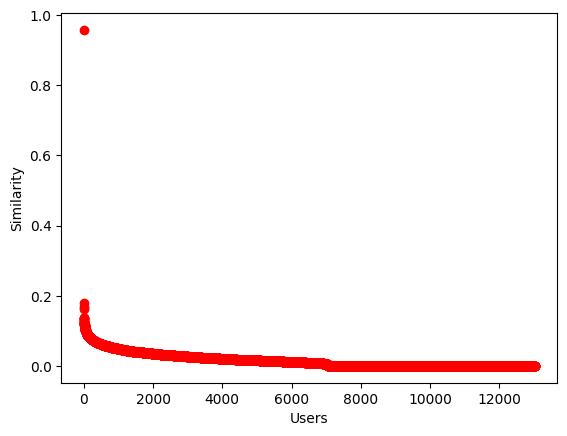

In [54]:
user_id = 64
shrink = 10

numerator_vector = urm_all.getrow(user_id).dot(urm_all.T).toarray().ravel()

user_norms = np.sqrt(np.array(urm_all.T.power(2).sum(axis=0))).ravel()
denominator_vector = user_norms[user_id] * user_norms + shrink + 1e-6

similarity_vector = numerator_vector/denominator_vector

sorted_user_indices = np.argsort(-similarity_vector)

pyplot.plot(similarity_vector[sorted_user_indices], 'ro')
pyplot.ylabel('Similarity')
pyplot.xlabel('Users')
pyplot.show()

Let's compute the whole similarity and see the predictions for a certain user

In [36]:
from Recommenders.Similarity.Compute_Similarity_Python import Compute_Similarity_Python

similarity_object = Compute_Similarity_Python(urm_all.T, shrink=shrink,
                                              topK=50, normalize=True,
                                              similarity = "cosine")

W_sparse = similarity_object.compute_similarity()

Similarity column 13025 (100.0%), 1036.59 column/sec. Elapsed time 12.57 sec


In [37]:
user_id = 61

scores = W_sparse[user_id,:].dot(urm_all).toarray().ravel()

ranking = scores.argsort()[::-1]

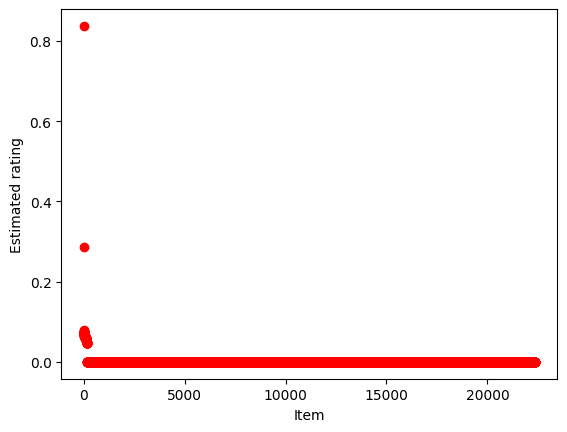

[ 215 3168 3153  728 4841  477  560 1658 5984 1141]


In [38]:
pyplot.plot(scores[ranking], 'ro')
pyplot.ylabel('Estimated rating')
pyplot.xlabel('Item')
pyplot.show()

print(ranking[:10])

**Build the predictor**

In [39]:
class UserKNNCFRecommender(object):

    def __init__(self, URM):
        self.URM = URM


    def fit(self, topK=50, shrink=10, normalize=True, similarity="cosine"):

        similarity_object = Compute_Similarity_Python(self.URM.T, shrink=shrink,
                                                  topK=topK, normalize=normalize,
                                                  similarity = similarity)

        self.W_sparse = similarity_object.compute_similarity()


    def recommend(self, user_id, at=None, exclude_seen=True,users_not_in_train=[]):

        # Check if user_id not in train use the topRec
        if user_id in users_not_in_train:
            return ["517 189 44 0 284 808 285 1 557 1266"]

        # compute the scores using the dot product

        scores = self.W_sparse[user_id, :].dot(self.URM).toarray().ravel()

        if exclude_seen:
            scores = self.filter_seen(user_id, scores)

        # rank items
        ranking = scores.argsort()[::-1]

        return ranking[:at]


    def filter_seen(self, user_id, scores):

        start_pos = self.URM.indptr[user_id]
        end_pos = self.URM.indptr[user_id+1]

        user_profile = self.URM.indices[start_pos:end_pos]

        scores[user_profile] = -np.inf

        return scores

# Fine-tune the hyperparametrs

In [60]:
def precision(recommended_items, relevant_items):

    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)

    precision_score = np.sum(is_relevant, dtype=np.float32) / len(is_relevant)

    return precision_score

def recall(recommended_items, relevant_items):

    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)

    recall_score = np.sum(is_relevant, dtype=np.float32) / relevant_items.shape[0]

    return recall_score

def AP(recommended_items, relevant_items):

    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)

    # Cumulative sum: precision at 1, at 2, at 3 ...
    p_at_k = is_relevant * np.cumsum(is_relevant, dtype=np.float32) / (1 + np.arange(is_relevant.shape[0]))

    ap_score = np.sum(p_at_k) / np.min([relevant_items.shape[0], is_relevant.shape[0]])

    return ap_score

def evaluate_algorithm(URM_test, recommender_object, at=10):

    cumulative_precision = 0.0
    cumulative_recall = 0.0
    cumulative_AP = 0.0

    num_eval = 0


    for user_id in range(URM_test.shape[0]):

        relevant_items = URM_test.indices[URM_test.indptr[user_id]:URM_test.indptr[user_id+1]]

        if len(relevant_items)>0:

            recommended_items = recommender_object.recommend(user_id, at=at)
            num_eval+=1

            cumulative_precision += precision(recommended_items, relevant_items)
            cumulative_recall += recall(recommended_items, relevant_items)
            cumulative_AP += AP(recommended_items, relevant_items)

    mean_precision = cumulative_precision / num_eval
    mean_recall = cumulative_recall / num_eval
    MAP = cumulative_AP / num_eval

    print("Recommender results are: Precision = {:.4f}, Recall = {:.4f}, MAP = {:.4f}".format(
        cumulative_precision, cumulative_recall, MAP))
    return MAP, mean_precision, mean_recall

Split the data into train/val


In [56]:
train_test_split = 0.80

n_interactions = urm_all.nnz

train_mask = np.random.choice([True,False], n_interactions, p=[train_test_split, 1-train_test_split])

urm_train = sps.csr_matrix((urm_all.data[train_mask],
                            (urm_all.row[train_mask], urm_all.col[train_mask])))

val_mask = np.logical_not(train_mask)

urm_val = sps.csr_matrix((urm_all.data[val_mask],
                            (urm_all.row[val_mask], urm_all.col[val_mask])))

Define the k data partitions for k-folds cross-validation

In [108]:
from sklearn.model_selection import KFold

n_interactions = urm_all.nnz
num_folds = 10

kf = KFold(n_splits=num_folds,  shuffle = True)
data_folds = []
indices = np.arange(n_interactions)
for train_inc, val_inc in kf.split(indices):
  train_mask = np.full(n_interactions,True)
  train_mask[val_inc] = False
  val_mask = np.logical_not(train_mask)

  fold_urm_train = sps.csr_matrix((urm_all.data[train_mask],
                            (urm_all.row[train_mask], urm_all.col[train_mask])))
  fold_urm_val = sps.csr_matrix((urm_all.data[val_mask],
                            (urm_all.row[val_mask], urm_all.col[val_mask])))
  data_folds.append({"train":fold_urm_train,"val":fold_urm_val})


**Implement the iterative random hyperparameter search with k-fold cross-validation**

Number of the most similar neighbours to consider

In [105]:
rnd_k = loguniform.rvs(10, 2000, size=11).astype(int)
rnd_shrink = loguniform.rvs(1, 1000, size=11).astype(int)
print(rnd_k)
print(rnd_shrink)

[ 170   75   29  258  594 1219  861  251  338  413  425]
[  6  83  22 989 649 128  46 761 491   8  42]


In [109]:
hyperparameter_search_rnd = pd.DataFrame(columns = ["k", "MAP"])
hyperparameter_search_rnd["k"] = rnd_k
hyperparameter_search_rnd = hyperparameter_search_rnd.sort_values(by="k")

default_shrink = 5

for index in hyperparameter_search_rnd.index:
    folds_map = []
    for k,fold in enumerate(data_folds):
      print(f'Fold {k} evaluations started')
      recommender = UserKNNCFRecommender(fold['train'])
      recommender.fit(shrink=default_shrink, topK=hyperparameter_search_rnd.loc[index,"k"])

      map, mp,mr = evaluate_algorithm(fold['val'],recommender)
      folds_map.append(map)

    cv_map = np.array(folds_map).sum()/len(data_folds)
    print(f'The crossvalidation MAP for {hyperparameter_search_rnd.loc[index,"k"]} is {cv_map}')
    hyperparameter_search_rnd.loc[index,"MAP"] = cv_map

Fold 0 evaluations started
Similarity column 13025 (100.0%), 1375.48 column/sec. Elapsed time 9.47 sec
Recommender results are: Precision = 271.8000, Recall = 693.5555, MAP = 0.0390
Fold 1 evaluations started
Similarity column 13025 (100.0%), 1264.45 column/sec. Elapsed time 10.30 sec
Recommender results are: Precision = 273.6000, Recall = 727.4385, MAP = 0.0389
Fold 2 evaluations started
Similarity column 13025 (100.0%), 1394.24 column/sec. Elapsed time 9.34 sec
Recommender results are: Precision = 273.8000, Recall = 713.5460, MAP = 0.0407
Fold 3 evaluations started
Similarity column 13025 (100.0%), 1247.10 column/sec. Elapsed time 10.44 sec
Recommender results are: Precision = 279.4000, Recall = 712.2186, MAP = 0.0393
Fold 4 evaluations started
Similarity column 13025 (100.0%), 872.47 column/sec. Elapsed time 14.93 sec
Recommender results are: Precision = 274.2000, Recall = 686.5140, MAP = 0.0363
Fold 5 evaluations started
Similarity column 13025 (100.0%), 1425.61 column/sec. Elapsed

       k       MAP
2     29  0.038285
1     75  0.049383
0    170  0.054322
7    251  0.055581
3    258  0.055616
8    338  0.055503
9    413  0.055499
10   425  0.055297
4    594  0.054149
6    861  0.051903
5   1219  0.049139


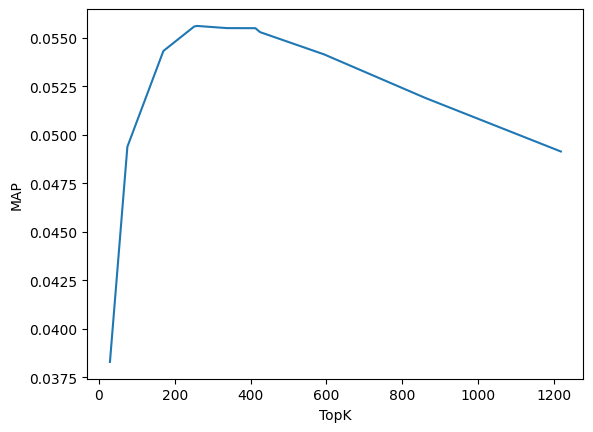

In [110]:
print(hyperparameter_search_rnd)

pyplot.plot(hyperparameter_search_rnd["k"].values, hyperparameter_search_rnd["MAP"].values)
pyplot.ylabel('MAP')
pyplot.xlabel('TopK')
pyplot.show()

Shrinkage

In [111]:
best_k_value = hyperparameter_search_rnd.loc[hyperparameter_search_rnd["MAP"].astype(float).idxmax()]

In [112]:
hyperparameter_search_rnd = pd.DataFrame(columns = ["k", "shrink", "MAP"])
hyperparameter_search_rnd["shrink"] = rnd_shrink
hyperparameter_search_rnd = hyperparameter_search_rnd.sort_values(by="shrink")
hyperparameter_search_rnd["k"] = best_k_value["k"]


for index in hyperparameter_search_rnd.index:
    folds_map = []
    for k,fold in enumerate(data_folds):
      print(f'Fold {k} evaluations started')
      recommender = UserKNNCFRecommender(fold['train'])
      recommender.fit(shrink=hyperparameter_search_rnd.loc[index,"shrink"], topK=best_k_value["k"])

      map, mp,mr = evaluate_algorithm(fold['val'],recommender)
      folds_map.append(map)

    cv_map = np.array(folds_map).sum()/len(data_folds)
    print(f'The crossvalidation MAP for {hyperparameter_search_rnd.loc[index,"shrink"]} is {cv_map}')
    hyperparameter_search_rnd.loc[index,"MAP"] = cv_map

Fold 0 evaluations started
Similarity column 13025 (100.0%), 961.12 column/sec. Elapsed time 13.55 sec
Recommender results are: Precision = 397.9000, Recall = 1039.5895, MAP = 0.0558
Fold 1 evaluations started
Similarity column 13025 (100.0%), 843.39 column/sec. Elapsed time 15.44 sec
Recommender results are: Precision = 401.5000, Recall = 1052.7828, MAP = 0.0570
Fold 2 evaluations started
Similarity column 13025 (100.0%), 947.94 column/sec. Elapsed time 13.74 sec
Recommender results are: Precision = 401.1000, Recall = 1032.9882, MAP = 0.0584
Fold 3 evaluations started
Similarity column 13025 (100.0%), 979.06 column/sec. Elapsed time 13.30 sec
Recommender results are: Precision = 404.5000, Recall = 1019.8333, MAP = 0.0541
Fold 4 evaluations started
Similarity column 13025 (100.0%), 953.48 column/sec. Elapsed time 13.66 sec
Recommender results are: Precision = 409.1000, Recall = 1056.9776, MAP = 0.0562
Fold 5 evaluations started
Similarity column 13025 (100.0%), 986.27 column/sec. Elaps

      k  shrink       MAP
0   258       6  0.055428
9   258       8  0.055208
2   258      22  0.053151
10  258      42  0.050642
6   258      46  0.050535
1   258      83  0.049015
5   258     128  0.048007
8   258     491  0.046846
4   258     649  0.046734
7   258     761  0.046742
3   258     989  0.046759


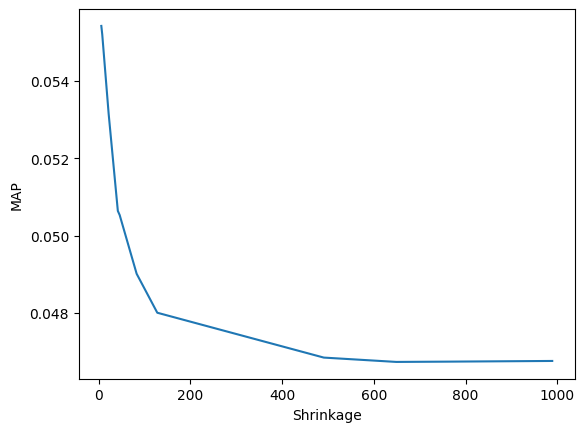

In [113]:
print(hyperparameter_search_rnd)

pyplot.plot(hyperparameter_search_rnd["shrink"].values, hyperparameter_search_rnd["MAP"].values)
pyplot.ylabel('MAP')
pyplot.xlabel('Shrinkage')
pyplot.show()

In [114]:
best_shrink = hyperparameter_search_rnd.loc[hyperparameter_search_rnd["MAP"].astype(float).idxmax()]
best_shrink

k              258
shrink           6
MAP       0.055428
Name: 0, dtype: object

Comparing different similarity heuristics

In [115]:
similarity_heuristic_list = ["cosine", "dice", "jaccard", "pearson"]
hyperparameter_search_rnd = pd.DataFrame(columns = ["k", "shrink","similarity", "MAP"])
hyperparameter_search_rnd["similarity"] = similarity_heuristic_list
hyperparameter_search_rnd["k"] = best_k_value["k"]
hyperparameter_search_rnd["shrink"] = best_shrink["shrink"]

for index in hyperparameter_search_rnd.index:
    folds_map = []
    for k,fold in enumerate(data_folds):
      print(f'Fold {k} evaluations started')
      recommender = UserKNNCFRecommender(fold['train'])
      recommender.fit(shrink=best_shrink["shrink"], topK=best_k_value["k"], similarity = hyperparameter_search_rnd.loc[index,"similarity"])

      map, mp,mr = evaluate_algorithm(fold['val'],recommender)
      folds_map.append(map)

    cv_map = np.array(folds_map).sum()/len(data_folds)
    print(f'The crossvalidation MAP for {hyperparameter_search_rnd.loc[index,"shrink"]} is {cv_map}')
    hyperparameter_search_rnd.loc[index,"MAP"] = cv_map

Fold 0 evaluations started
Similarity column 13025 (100.0%), 981.66 column/sec. Elapsed time 13.27 sec
Recommender results are: Precision = 397.9000, Recall = 1039.5895, MAP = 0.0558
Fold 1 evaluations started
Similarity column 13025 (100.0%), 1005.30 column/sec. Elapsed time 12.96 sec
Recommender results are: Precision = 401.5000, Recall = 1052.7828, MAP = 0.0570
Fold 2 evaluations started
Similarity column 13025 (100.0%), 996.67 column/sec. Elapsed time 13.07 sec
Recommender results are: Precision = 401.1000, Recall = 1032.9882, MAP = 0.0584
Fold 3 evaluations started
Similarity column 13025 (100.0%), 994.96 column/sec. Elapsed time 13.09 sec
Recommender results are: Precision = 404.5000, Recall = 1019.8333, MAP = 0.0541
Fold 4 evaluations started
Similarity column 13025 (100.0%), 968.98 column/sec. Elapsed time 13.44 sec
Recommender results are: Precision = 409.1000, Recall = 1056.9776, MAP = 0.0562
Fold 5 evaluations started
Similarity column 13025 (100.0%), 976.59 column/sec. Elap

     k  shrink similarity       MAP
0  258       6     cosine  0.055428
1  258       6       dice  0.053363
2  258       6    jaccard  0.053354
3  258       6    pearson  0.000053


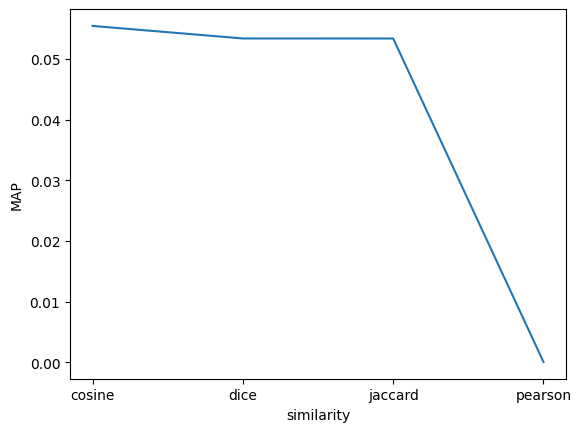

In [116]:
print(hyperparameter_search_rnd)

pyplot.plot(hyperparameter_search_rnd["similarity"].values, hyperparameter_search_rnd["MAP"].values)
pyplot.ylabel('MAP')
pyplot.xlabel('similarity')
pyplot.show()

# Make the recommendatoins

In [117]:
urm_all_train = sps.csr_matrix((urm_all.data,
                            (urm_all.row, urm_all.col)))

In [118]:
recommender = UserKNNCFRecommender(urm_all_train)
recommender.fit(topK = 258,shrink=6)

Similarity column 13025 (100.0%), 876.62 column/sec. Elapsed time 14.86 sec


**Now let's read the data we want to predict for and see if there're overlaps with UserIDs in train data**

In [119]:
urm_pred_path = '/content/data_target_users_test.csv'

urm_pred_df = pd.read_csv(filepath_or_buffer=urm_pred_path,
                                sep=",",
                                header=0,
                                dtype={0:int},
                                engine='python')

urm_pred_df.columns = ["UserID"]
len(urm_pred_df['UserID'])
print('Unique user id to predict:', urm_pred_df['UserID'].nunique())

Unique user id to predict: 10882


**Now we make the predictions for every user in our test set and add them to pred_df**

Here we list the users that are in our test set but not in our whole train set

In [120]:
users_not_in_train = urm_pred_df[~urm_pred_df['UserID'].isin(urm_all_df['UserID'])]

print("Users in urm_pred_df but not in urm_all_orgdf:")
print(users_not_in_train)
print(len(users_not_in_train))

users_not_in_train = users_not_in_train['UserID'].to_numpy()

Users in urm_pred_df but not in urm_all_orgdf:
       UserID
54         60
58         65
147       168
223       261
272       316
...       ...
10682   12775
10699   12798
10729   12837
10802   12921
10856   12992

[221 rows x 1 columns]
221


In [121]:
usr_id_notintrain = 60
recommendations = recommender.recommend(usr_id_notintrain, at=10, users_not_in_train=users_not_in_train)
print(recommendations)

['517 189 44 0 284 808 285 1 557 1266']


In [123]:
pred_df = pd.DataFrame(columns = ['user_id','item_list'])

for userid in urm_pred_df['UserID']:
  recommendations = recommender.recommend(userid, at=10, users_not_in_train=users_not_in_train)
  recommendations = " ".join(str(item) for item in recommendations)
  pred_df.loc[len(pred_df)] = [userid,recommendations]

In [124]:
pred_df

,user_id,item_list
0,1,101 36 403 506 977 515 1546 9 112 869
1,2,2 5 3 4 8 47 6 19 12 14
2,3,59 648 536 259 584 956 999 13 117 5
3,4,28 50 1 2 6 5 145 4 3 249
4,5,51 4 215 26 8 59 131 1264 77 341
...,...,...
10877,13020,506 6450 161 34 337 51 6452 403 159 6198
10878,13021,133 139 254 1 8 36 2 593 13 6179
10879,13022,1411 1668 1446 1674 809 2 23 1610 20 31
10880,13023,129 32 242 3 89 82 313 639 2 308


In [126]:
pred_df.to_csv('/content/predUBCF_Max.csv',index=False)